## Технологии машинного обучения

## Практическая 4. Обучение без учителя

### О задании

В этом задании мы посмотрим на несколько алгоритмов кластеризации и применим их к текстовым данным (тематическое моделирование) 

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. 


In [1]:
import pandas as pd
import numpy as np

np.random.seed(0xFFFFFFF)

## Тематическое моделирование текстов

В этой работе мы познакомимся с одной из самых популярных задач обучения без учителя &mdash; с задачей тематического моделирования текстов. Допустим, нам доступна некоторая коллекция документов без разметки, и мы хотим автоматически выделить несколько тем, которые встречаются в документах, а также присвоить каждому документу одну (или несколько) тем. Фактически, мы будем решать задачу, похожую на кластеризацию текстов: отличие в том, что нас будет интересовать не только разбиение текстов на группы, но и выделение ключевых слов, определяющих каждую тему.

Мы будем работать с новостными статьями BBC за 2004-2005 годы. Скачайте данные по [ссылке](https://www.kaggle.com/hgultekin/bbcnewsarchive).

In [2]:
!wget -O 'bbc-news-data.csv' -q 'https://www.dropbox.com/s/f93jwyekh4zsu3y/bbc-news-data.csv?dl=0'

In [3]:
data = pd.read_csv('bbc-news-data.csv', sep='\t')
data.sample(5)

,category,filename,title,content
1289,politics,394.txt,Economy focus for election battle,Britain's economic future will be at the hear...
1872,tech,049.txt,Domain system scam fear,A system to make it easier to create website ...
1044,politics,149.txt,Blair returns from peace mission,Prime Minister Tony Blair has arrived back fr...
654,entertainment,145.txt,Sir Paul rocks Super Bowl crowds,Sir Paul McCartney wowed fans with a live min...
134,business,135.txt,Feta cheese battle reaches court,A row over whether only Greece should be allo...


Как вы могли заметить, данные уже содержат разметку по тематике (колонка category). В этой работе мы забудем, что она есть, и будем работать только с текстовыми данными. Проведем предобработку текста, состоящую из следующих пунктов:

* Объединим заголовок и содержание статьи в одно поле.
* Приведем текст к нижнему регистру, разобьем его на токены.
* Оставим только буквенные слова (удалив, таким образом, пунктуацию и числа).
* Применим лемматизацию.
* Удалим стоп-слова.


In [4]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [5]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english') + ['ha', 'wa', 'say', 'said'])
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
def preprocess(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

In [7]:
data['raw_text'] = data.apply(lambda row: row.title + row.content, axis=1)
data['text'] = data.apply(lambda row: preprocess(row.raw_text), axis=1)

Для визуализации частот слов в текстах мы будем использовать [облака тегов](https://en.wikipedia.org/wiki/Tag_cloud).

In [8]:
from wordcloud import WordCloud

def draw_wordcloud(texts, max_words=1000, width=1000, height=500):
    wordcloud = WordCloud(background_color='white', max_words=max_words,
                          width=width, height=height)
    
    joint_texts = ' '.join(list(texts))
    wordcloud.generate(joint_texts)
    return wordcloud.to_image()

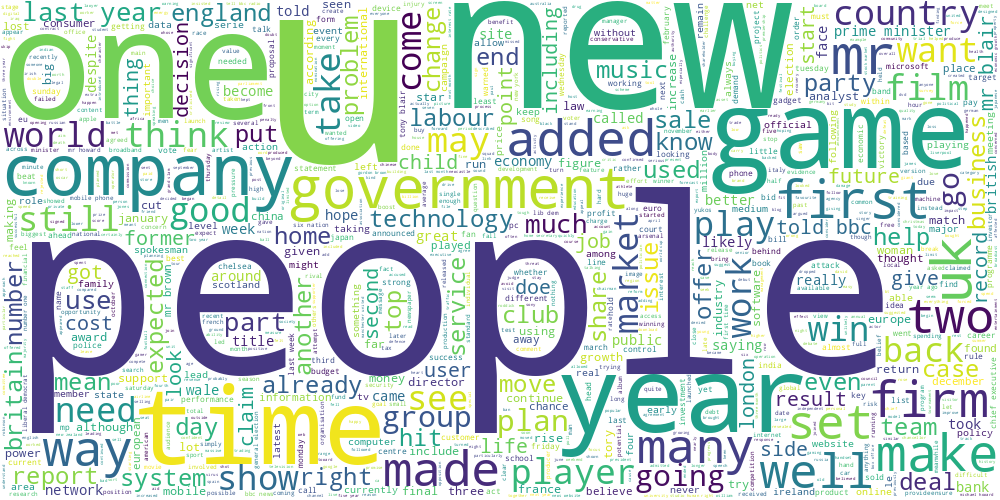

In [9]:
draw_wordcloud(data.text)

**Задание 1 (3 балла).** Обучите алгоритм K-Means на tf-idf представлениях текстов. При обучении [tf-idf векторайзера](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) рекомендуется отбрасывать редко встречающиеся слова, а также воздержитесь от использования N-грамм. Возьмите не очень большое число кластеров, чтобы было удобно интерпретировать получившиеся темы (например, `n_clusters` = 8). Постройте облака тегов для текстов из разных кластеров. Получились ли темы интерпретируемыми? Попробуйте озаглавить каждую тему.

**Ответ:**

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
data.shape

(2225, 6)

In [12]:
# отсекаются наиболее редкие термы, используются только униграммы
vectorizer_tfidf = TfidfVectorizer(min_df=0.001, ngram_range=(1, 1))
X = vectorizer_tfidf.fit_transform(data.text)

In [13]:
kmeans = KMeans(n_clusters=8, n_init="auto")
cluster_idxs = kmeans.fit_predict(X)
data['cluster'] = cluster_idxs

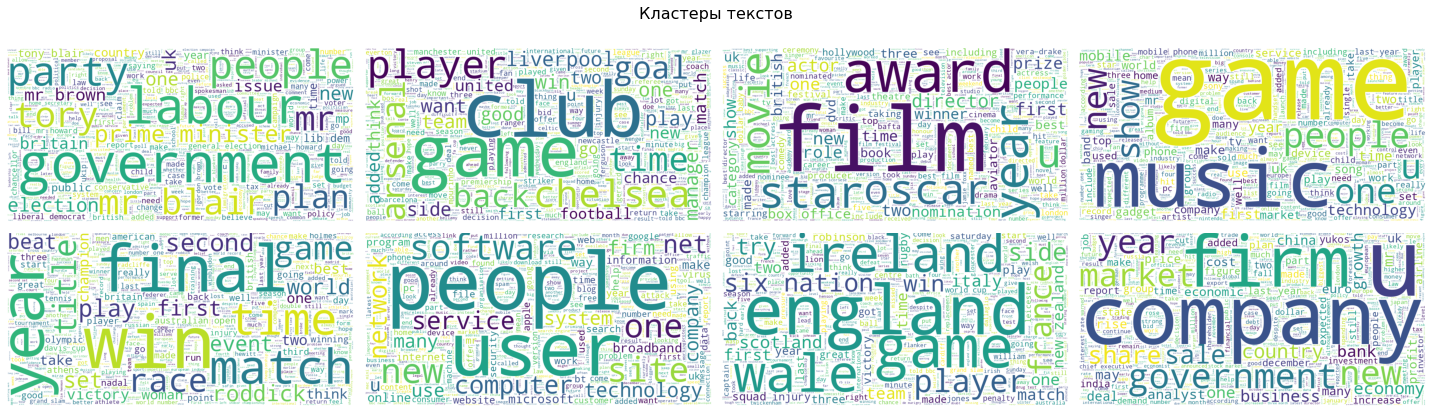

In [14]:
plt.figure(figsize=(20, 6))

for i in range(8):
    plt.subplot(2, 4, i+1)
    plt.axis('off')
    img = draw_wordcloud(data[data['cluster'] == i]['text'])
    plt.imshow(img)

plt.suptitle('Кластеры текстов', fontsize=16)
plt.tight_layout()

(Слева направо в две строки):
1. Политика в сфере труда и выборы
2. Футбол
3. Кинематограф
4. Музыка и гаджеты
5. Спорт
6. Информационные технологии
7. Кубок шести наций
8. Рынок и бизнес

**Задание 2 (3 балла).** Попробуем другой способ выделить ключевые слова для каждой темы. Помимо непосредственного разбиения объектов алгоритм K-Means получает центр каждого кластера. Попробуйте взять центры кластеров и посмотреть на слова, для которых значения соответствующих им признаков максимальны. Согласуются ли полученные слова с облаками тегов из прошлого задания?

**Ответ:**

In [15]:
kmeans.cluster_centers_

array([[0.        , 0.        , 0.00013107, ..., 0.00026351, 0.        ,
        0.        ],
       [0.        , 0.00046601, 0.        , ..., 0.00096753, 0.        ,
        0.00051577],
       [0.        , 0.        , 0.        , ..., 0.00037548, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.00029636, ..., 0.00072061, 0.        ,
        0.        ],
       [0.        , 0.00118453, 0.        , ..., 0.00043962, 0.        ,
        0.00467434],
       [0.        , 0.        , 0.0001861 , ..., 0.00145505, 0.        ,
        0.00042204]])

In [16]:
features = vectorizer_tfidf.get_feature_names_out()
max_idxs = np.argmax(kmeans.cluster_centers_, axis=1)

In [17]:
features[max_idxs]

array(['mr', 'club', 'film', 'music', 'open', 'user', 'england',
       'company'], dtype=object)

В целом, полученные слова согласуются с облаками тегов. В первой теме большой вес имеет тег "mr", что говорит об официальности текстов, принадлежащих этому кластеру.

**Задание 3 (4 балла).** Сравним три разных алгоритма кластеризации на наших текстовых данных (в качестве признакого описания снова используем tf-idf). Получите три разбиения на кластеры с помощью алгоритмов **K-Means**, **DBSCAN** и **спектральной кластеризации** (воспользуйтесь реализациями из `sklearn`). Для K-Means и спектральной кластеризации возьмите одинаковое небольшое число кластеров, подберите параметр `eps` метода DBSCAN так, чтобы получить приблизительно такое же число кластеров.

Далее, обучите двухмерные t-SNE представления над tf-idf признаками текстов. Визуализируйте эти представления для каждого алгоритма, раскрасив каждый кластер своим цветом. Лучше всего расположить визуализации на одном графике на трех разных сабплотах. Не забудьте, что DBSCAN помечает некоторые точки как шумовые (можно раскрасить их в отдельный цвет).

In [18]:
kmeans = KMeans(n_clusters=8, n_init="auto")
kmeans_topics = kmeans.fit_predict(X)

In [19]:
dbscan = DBSCAN(eps=1.255)
dbscan_topics = dbscan.fit_predict(X)
np.unique(dbscan_topics) # +1 кластер для выбросов

array([-1,  0,  1,  2,  3,  4,  5,  6,  7])

In [20]:
spectral = SpectralClustering(n_clusters=8)
spectral_topics = spectral.fit_predict(X)

In [21]:
tsne = TSNE(init="random", n_components=2)
tsne_repr = tsne.fit_transform(X)

In [22]:
tsne_result = pd.concat([
    pd.DataFrame(kmeans_topics, columns=['kmeans']),
    pd.DataFrame(dbscan_topics, columns=['dbscan']),
    pd.DataFrame(spectral_topics, columns=['spectral']),
    pd.DataFrame(tsne_repr, columns=['tsne_1','tsne_2'])
], axis=1)

In [23]:
tsne_result.head(5)

,kmeans,dbscan,spectral,tsne_1,tsne_2
0,7,0,0,29.778526,-0.126004
1,1,0,7,40.273163,18.960581
2,7,0,3,49.899448,32.280041
3,7,0,7,24.674164,11.257332
4,7,-1,0,12.677233,0.447422


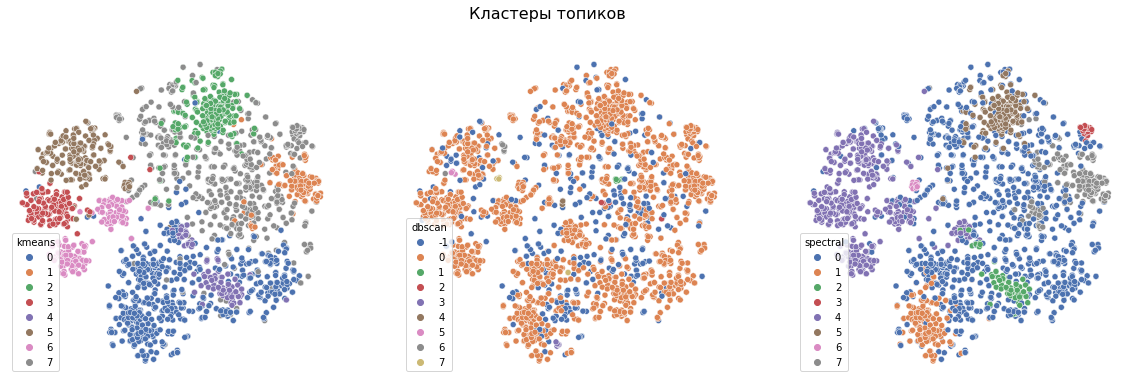

In [24]:
fig, axs = plt.subplots(ncols=3, figsize=(20,6))

sns.scatterplot(data=tsne_result, x="tsne_1", y="tsne_2", hue='kmeans', ax=axs[0], palette="deep")
axs[0].axis('off')

sns.scatterplot(data=tsne_result, x="tsne_1", y="tsne_2", hue='dbscan', ax=axs[1], palette="deep")
axs[1].axis('off')

sns.scatterplot(data=tsne_result, x="tsne_1", y="tsne_2", hue='spectral', ax=axs[2], palette="deep")
axs[2].axis('off')

fig.suptitle('Кластеры топиков', fontsize='16')
plt.show()